# Convolutional Neural Networks

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import tarfile
from skimage.io import imread, imshow
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical

warnings.filterwarnings("ignore")

/Users/michalmacbook/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
# utility functions
def zero_pad(X, pad):
    return np.pad(X, ((pad, pad), (pad, pad), (0, 0)), 'constant')

def load_data():

    with tarfile.open('./data.tar.gz', 'r') as f:
        f.extractall()

    df_train = pd.read_csv('fashion_mnist_train.csv')
    df_test = pd.read_csv('fashion_mnist_test.csv')

    x_train = df_train.drop('label', axis=1).as_matrix().astype(np.uint8)
    y_train = df_train['label'].as_matrix().astype(np.uint8)
    x_test = df_test.drop('label', axis=1).as_matrix().astype(np.uint8)
    y_test = df_test['label'].as_matrix().astype(np.uint8)

    return (x_train, y_train), (x_test, y_test)

img = imread('./logo.png') # the test image we will be using
kernel = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
kernel = np.stack([kernel]*3, axis=2)

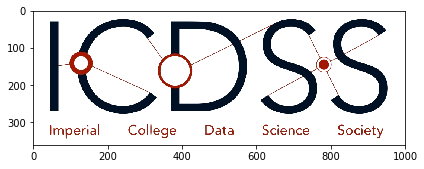

In [3]:
imshow(img)

## Convolutional neural net building blocks

### Convolutional layer

In [4]:
def conv2d(X, W):
    out = np.zeros(X.shape[:2])
    kernel_size = W.shape[0]
    X = zero_pad(X, (kernel_size - 1) // 2) # see next section
    
    # slide the kernel accross the width and height
    for i in range(0, X.shape[0] - kernel_size + 1, 1):
        for j in range(0, X.shape[1] - kernel_size+ 1, 1):
            # compute the dot product between each entry of the kernel and the input
                out[i, j] = np.sum(X[i:i+kernel_size, j:j+kernel_size, :] * W)
    return out

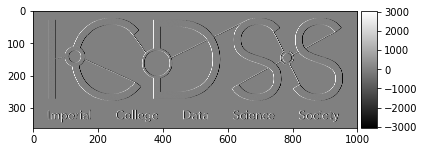

In [5]:
convolved = conv2d(img, kernel)
imshow(convolved, cmap='gray')

### Padding and strides

**Padding** and **stride** determine the conv layer output size.   

'same' padding means that the output will have the same spatial dimensions as the input. 'valid' padding is equivalent to no padding, i.e. the output will be smaller than the input.   

Stride determines by how much the kernel is moved between feature computations (by how many pixels we 'slide' it). 

In practice, we usually use 'same' padding and stride 1 for the convolutional layers - output has the same spatial dimensions as the input. However, those parameters are important in *pooling layers* (see below).  

Read [this guide](https://arxiv.org/pdf/1603.07285.pdf) for an in-depth look at convolution arithmetics.

In [6]:
def compute_output_shape(input_shape, kernel_size, pad, stride):
    return ((input_shape[0] - kernel_size + 2 * pad) // stride + 1,
            (input_shape[1] - kernel_size + 2 * pad) // stride + 1)

def conv2d_padding(X, W, padding='same', stride=1):
    kernel_size = W.shape[0]
    
    if padding == 'same':
        pad = (kernel_size - 1) // 2
    elif padding == 'valid':
        pad = 0
    else:
        raise ArgumentError('{} is not a padding method. Possible options are "same" and valid"'.format(padding))
    

    output_shape = compute_output_shape(X.shape, kernel_size, pad, stride)
    
    out = np.zeros(output_shape)

    X = zero_pad(X, pad)
    
    # slide the kernel accross the width and height
    for i in range(0, X.shape[0] - kernel_size, stride):
        for j in range(0, X.shape[1] - kernel_size, stride):
            # compute the dot product between each entry of the kernel and the input
                out[i // stride, j // stride] = np.sum(X[i:i+kernel_size, j:j+kernel_size, :] * W)
    return out

In [7]:
same_1 = conv2d_padding(img, kernel)
valid_2 = conv2d_padding(img, kernel, 'valid', 2)
same_1.shape, valid_2.shape

((361, 1000), (180, 499))

## Pooling

In [8]:
def max_pool(X, window_size, padding='valid', stride=2):

    if padding == 'same':
        pad = (window_size - 1) // 2
    elif padding == 'valid':
        pad = 0
    else:
        raise ArgumentError('{} is not a padding method. Possible options are "same" and valid"'.format(padding))
    

    output_shape = compute_output_shape(X.shape, window_size, pad, stride)
    
    out = np.zeros(output_shape + (X.shape[2], )) # pooling does not change the number of channels

    X = zero_pad(X, pad)
    
    # slide the kernel accross the width and height
    for i in range(0, X.shape[0] - window_size, stride):
        for j in range(0, X.shape[1] - window_size, stride):
            # pooling operates on each channel independently
            for k in range(X.shape[2]):
                out[i // stride, j // stride, k] = np.max(X[i:i+window_size, j:j+window_size, k])
    return out

In [9]:
pooled = max_pool(img, 2)

In [10]:
pooled.shape

(180, 500, 3)

## Dropout

In [11]:
def dropout(X, p):
    mask = np.random.binomial(1, p, X.shape) # equivalent of flipping a coin with probability p for each input
    return np.where(mask, X, 0.) 

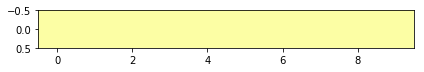

In [12]:
x = np.random.random((1, 10))
imshow(x > 0, cmap='inferno')

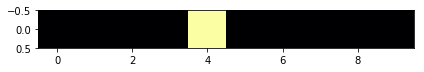

In [13]:
imshow(dropout(x, .5) > 0, cmap='inferno')

## Full network implementation in Keras

In [18]:
# load the data
(x_train, y_train), (x_test, y_test) = load_data()
y_train = to_categorical(y_train) # convert to one-hot encoding
y_test = to_categorical(y_test)

### Standard feedforward neural network

In [ ]:
feedforward = Sequential()
feedforward.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
feedforward.add(Dropout(0.5))
feedforward.add(Dense(64, activation='relu'))
feedforward.add(Dropout(0.5))
feedforward.add(Dense(10, activation='softmax'))

feedforward.compile(loss='categorical_crossentropy',
                    optimizer='rmsprop',
                    metrics=['accuracy'])

feedforward.summary()

In [ ]:
feedforward.fit(x_train, y_train,
                epochs=20,
                batch_size=128)

In [ ]:
# if the training is too slow
feedforward = load_model('../models/feedforward.h5')

In [ ]:
_, score_ff = feedforward.evaluate(x_test, y_test, batch_size=128)
score_ff

### A simple convnet from scratch

In [19]:
x_train = x_train.reshape(-1, 28, 28, 1) # convnets use 3D inputs -
                                         # - since images are grayscale, number of channels is 1
x_test = x_test.reshape(-1, 28, 28, 1)

convnet = Sequential()
convnet.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
convnet.add(MaxPooling2D(pool_size=(2, 2)))

convnet.add(Conv2D(32, (3, 3), activation='relu'))
convnet.add(MaxPooling2D(pool_size=(2, 2)))

convnet.add(Conv2D(64, (3, 3), activation='relu'))
convnet.add(MaxPooling2D(pool_size=(2, 2)))

convnet.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors - 
                        # - needed for the fully-connected layers
convnet.add(Dense(64, activation='relu'))
convnet.add(Dropout(0.5))
convnet.add(Dense(10, activation='softmax'))

convnet.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

In [20]:
convnet.fit(x_train, y_train,
            epochs=5,
            batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 27s 454us/step - loss: 1.0105 - acc: 0.6778
Epoch 2/5
60000/60000 [==============================] - 27s 458us/step - loss: 0.5769 - acc: 0.7968
Epoch 3/5
60000/60000 [==============================] - 26s 427us/step - loss: 0.5072 - acc: 0.8210
Epoch 4/5
60000/60000 [==============================] - 25s 417us/step - loss: 0.4658 - acc: 0.8350
Epoch 5/5
60000/60000 [==============================] - 26s 438us/step - loss: 0.4389 - acc: 0.8468


In [ ]:
# if the training is too slow
convnet = load_model('../models/convnet.h5')

In [ ]:
_, score_conv = convnet.evaluate(x_test, y_test, batch_size=128)
score_conv

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False)

datagen.fit(x_train)
convnet.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

convnet.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                      steps_per_epoch=len(x_train) / 128, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.9750 - acc: 0.6486
Epoch 2/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7538 - acc: 0.7318
Epoch 3/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7164 - acc: 0.7482
Epoch 4/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7060 - acc: 0.7563
Epoch 5/5
 457/1875 [======>.......................] - ETA: 28s - loss: 0.7107 - acc: 0.7570

## Further exercises
- There is an asymptotically faster way of doing convolutions. Implement this method (*note:* use only one channel for simplicity (i.e. no depth).   
*Hint:* there is a transform $T$ such that $T(W * X) = T(W)T(X)$, i.e. convolution is equivalent to multiplication under the transform.
- It can be shown that spatial convolution can be rewritten in terms of matrix multiplication. Try to implement this approach. This does not improve the asymptotical complexity. However, most modern DL libraries (including ```Tensorflow```) use this method. Why?  
*Hint:* read [this](http://cs231n.github.io/convolutional-networks/#conv) and investigate ```im2col```).
- A frequently used regularization technique, in addition to dropout, is *batch normalization*. It normalizes the activations after each layer so that they follow approximately standard normal distribution. Try experimenting with it in Keras (available as ```keras.layers.BatchNormalization```). How does it improve the training? Read [the original paper](https://arxiv.org/pdf/1502.03167.pdf) for further information.
- Find an interesting classification problem (if you're out of ideas, try the classic [dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) problem) and implement *transfer learning* to solve it. Keras makes several pre-trained models available in ```keras.applications``` - try VGG16 first. Test how many training images do you need to acheive good performance.